<a href="https://colab.research.google.com/github/rutokevin/HEALTHIT-MMUST-DATA-SCIENCE/blob/main/BTC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import matplotlib.pyplot as plt
import os
import re
import shutil
import string
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import losses

In [3]:
print(tf.__version__)

2.15.0


In [4]:
url = "https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"

dataset = tf.keras.utils.get_file("aclImdb_v1", url,
                                    untar=True, cache_dir='.',
                                    cache_subdir='')

dataset_dir = os.path.join(os.path.dirname(dataset), 'aclImdb')

84125825/84125825 [==============================] - 3s 0us/step


In [7]:
train_dir = os.path.join(dataset_dir, 'train')
os.listdir(train_dir)
sample_file = os.path.join(train_dir, 'pos/1000_8.txt')
with open(sample_file) as f:
  print(f.read())

I liked the film. Some of the action scenes were very interesting, tense and well done. I especially liked the opening scene which had a semi truck in it. A very tense action scene that seemed well done.<br /><br />Some of the transitional scenes were filmed in interesting ways such as time lapse photography, unusual colors, or interesting angles. Also the film is funny is several parts. I also liked how the evil guy was portrayed too. I'd give the film an 8 out of 10.


In [8]:
remove_dir = os.path.join(train_dir, 'unsup')

In [9]:
shutil.rmtree(remove_dir)

In [10]:
batch_size = 32
seed = 42
raw_train_ds = tf.keras.utils.text_dataset_from_directory(
    'aclImdb/train',
    batch_size = batch_size,
    validation_split = 0.2,
    subset = 'training',
    seed = seed
)

Found 25000 files belonging to 2 classes.
Using 20000 files for training.


In [11]:

for text_batch, label_batch in raw_train_ds.take(1):
  for i in range(3):
    print("Review", text_batch.numpy()[i])
    print("Label", label_batch.numpy()[i])

Review b'"Pandemonium" is a horror movie spoof that comes off more stupid than funny. Believe me when I tell you, I love comedies. Especially comedy spoofs. "Airplane", "The Naked Gun" trilogy, "Blazing Saddles", "High Anxiety", and "Spaceballs" are some of my favorite comedies that spoof a particular genre. "Pandemonium" is not up there with those films. Most of the scenes in this movie had me sitting there in stunned silence because the movie wasn\'t all that funny. There are a few laughs in the film, but when you watch a comedy, you expect to laugh a lot more than a few times and that\'s all this film has going for it. Geez, "Scream" had more laughs than this film and that was more of a horror film. How bizarre is that?<br /><br />*1/2 (out of four)'
Label 0
Review b"David Mamet is a very interesting and a very un-equal director. His first movie 'House of Games' was the one I liked best, and it set a series of films with characters whose perspective of life changes as they get into 

In [12]:
print("Label 0 ni ", raw_train_ds.class_names[0])
print("Label 1 ni ", raw_train_ds.class_names[1])

Label 0 ni  neg
Label 1 ni  pos


In [18]:
raw_val_ds = tf.keras.utils.text_dataset_from_directory(
    'aclImdb/train',
    batch_size = batch_size,
    validation_split=0.2,
    subset = 'validation',
    seed = seed
    )

Found 25000 files belonging to 2 classes.
Using 5000 files for validation.


In [19]:
raw_test_ds = tf.keras.utils.text_dataset_from_directory(
    'aclImdb/test',
    batch_size=batch_size
)

Found 25000 files belonging to 2 classes.


In [21]:
def custom_standardization(input_data):
  lowercase = tf.strings.lower(input_data)
  stripped_html = tf.strings.regex_replace(lowercase, '<br />', ' ')
  return tf.strings.regex_replace(stripped_html,
                                  '[%s]' % re.escape(string.punctuation),
                                  '')

In [23]:
max_features = 10000
sequence_Length = 250
vectorize_layer = layers.TextVectorization(
    standardize=custom_standardization,
    max_tokens = max_features,
    output_mode = 'int',
    output_sequence_length = sequence_Length
)

In [24]:
train_text = raw_train_ds.map(lambda x, y:x)
vectorize_layer.adapt(train_text)

In [25]:
def vectorize_text(text, label):
  text = tf.expand_dims(text, -1)
  return vectorize_layer(text), label

In [27]:
# retieve a batch of 32 reviews and labels
text_batch, label_batch = next(iter(raw_train_ds))
first_review, first_label = text_batch[0], label_batch[0]
print("Review", first_review)
print("Label", raw_train_ds.class_names[first_label])
print("Vectorized review", vectorize_text(first_review, first_label))



Review tf.Tensor(b'Belmondo is a tough cop. He goes after a big-time drug dealer (played by Henry Silva, normally a great villain - see "Sharky\'s Machine"; but here he is clearly dubbed, and because of that he lacks his usual charisma). He goes to the scuzziest places of Paris and Marseilles, asks for some names, beats up some people, gets the names, goes to more scuzzy places, asks for more names, beats up more people, etc. The whole movie is punch after punch after punch. It seems that the people who made it had no other ambition than to create the French equivalent of "Dirty Harry". Belmondo, who was 50 here, does perform some good stunts at the beginning; apart from those, "Le Marginal" is a violent, episodic, trite, shallow and forgettable cop movie. (*1/2)', shape=(), dtype=string)
Label neg
Vectorized review (<tf.Tensor: shape=(1, 250), dtype=int64, numpy=
array([[   1,    7,    4, 1233, 1021,   27,  261,  101,    4,    1, 1525,
        6992,  248,   32, 1488,    1, 1659,    4,

In [31]:
print("1021 ---> ",vectorize_layer.get_vocabulary()[1021])


1021 --->  cop


In [33]:
train_ds = raw_train_ds.map(vectorize_text)
val_ds = raw_val_ds.map(vectorize_text)
test_ds = raw_test_ds.map(vectorize_text)

In [34]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)



In [35]:
embedding_dim = 16

In [36]:
model = tf.keras.Sequential([
  layers.Embedding(max_features, embedding_dim),
  layers.Dropout(0.2),
  layers.GlobalAveragePooling1D(),
  layers.Dropout(0.2),
  layers.Dense(1)])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 16)          160000    
                                                                 
 dropout (Dropout)           (None, None, 16)          0         
                                                                 
 global_average_pooling1d (  (None, 16)                0         
 GlobalAveragePooling1D)                                         
                                                                 
 dropout_1 (Dropout)         (None, 16)                0         
                                                                 
 dense (Dense)               (None, 1)                 17        
                                                                 
Total params: 160017 (625.07 KB)
Trainable params: 160017 (625.07 KB)
Non-trainable params: 0 (0.00 Byte)
________________

In [37]:
model.compile(loss=losses.BinaryCrossentropy(from_logits=True),
              optimizer='adam',
              metrics=tf.metrics.BinaryAccuracy(threshold=0.0))

In [38]:
epochs =10
history = model.fit(
    train_ds, validation_data=val_ds,
    epochs = epochs
)

Epoch 1/10
625/625 [==============================] - 9s 12ms/step - loss: 0.6655 - binary_accuracy: 0.6867 - val_loss: 0.6169 - val_binary_accuracy: 0.7736
Epoch 2/10
625/625 [==============================] - 6s 10ms/step - loss: 0.5502 - binary_accuracy: 0.8004 - val_loss: 0.4996 - val_binary_accuracy: 0.8200
Epoch 3/10
625/625 [==============================] - 5s 7ms/step - loss: 0.4466 - binary_accuracy: 0.8422 - val_loss: 0.4215 - val_binary_accuracy: 0.8454
Epoch 4/10
625/625 [==============================] - 4s 7ms/step - loss: 0.3796 - binary_accuracy: 0.8652 - val_loss: 0.3749 - val_binary_accuracy: 0.8590
Epoch 5/10
625/625 [==============================] - 5s 8ms/step - loss: 0.3364 - binary_accuracy: 0.8765 - val_loss: 0.3461 - val_binary_accuracy: 0.8676
Epoch 6/10
625/625 [==============================] - 6s 9ms/step - loss: 0.3066 - binary_accuracy: 0.8875 - val_loss: 0.3266 - val_binary_accuracy: 0.8706
Epoch 7/10
625/625 [==============================] - 4s 7ms/s

In [40]:
loss, accuracy = model.evaluate(test_ds)

print("Loss: ", loss*100)
print("Accuracy: ", accuracy*100)

782/782 [==============================] - 1s 2ms/step - loss: 0.3102 - binary_accuracy: 0.8736
Loss:  31.016451120376587
Accuracy:  87.35600113868713


In [41]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])

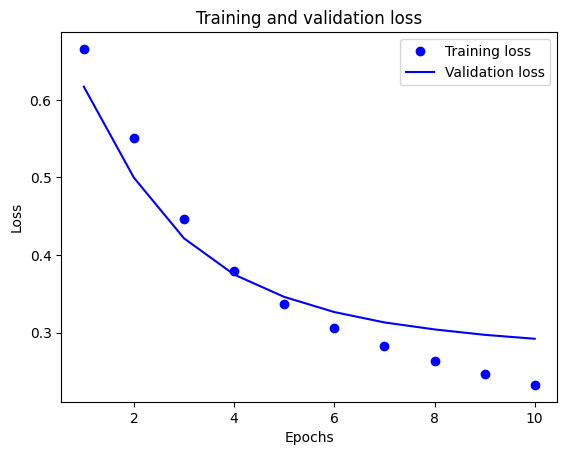

In [42]:
acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

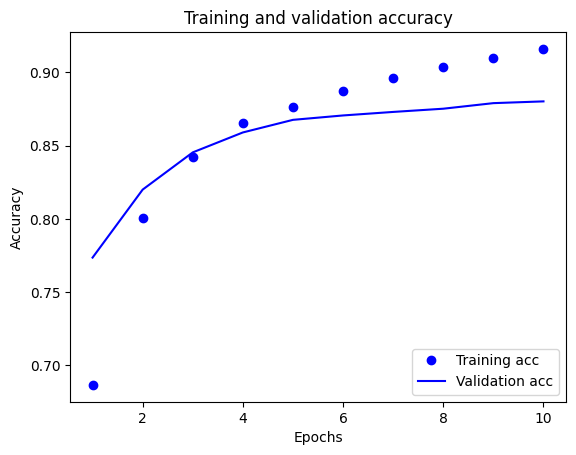

In [43]:
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.show()

In [44]:
export_model = tf.keras.Sequential([
  vectorize_layer,
  model,
  layers.Activation('sigmoid')
])

export_model.compile(
    loss=losses.BinaryCrossentropy(from_logits=False), optimizer="adam", metrics=['accuracy']
)

# Test it with `raw_test_ds`, which yields raw strings
loss, accuracy = export_model.evaluate(raw_test_ds)
print(accuracy)

782/782 [==============================] - 5s 6ms/step - loss: 0.3102 - accuracy: 0.8736
0.8735600113868713


In [45]:
examples = [
  "The movie was great!",
  "The movie was okay.",
  "The movie was terrible..."
]

export_model.predict(examples)

1/1 [==============================] - 0s 142ms/step


array([[0.6535698 ],
       [0.48009655],
       [0.3947923 ]], dtype=float32)

In [47]:
# Preprocess the examples using the vectorize_layer
import numpy as np

# Preprocess the examples using the vectorize_layer
numerical_examples = vectorize_layer(examples)

# Predict sentiment labels for the numerical examples
predictions = model.predict(numerical_examples)

# Convert probabilities to binary labels (0 for negative, 1 for positive)
binary_predictions = np.where(predictions >= 0.5, 1, 0)

# Print the predictions
for example, prediction in zip(examples, binary_predictions):
    sentiment = "positive" if prediction == 1 else "negative"
    print(f"Sentence: '{example}' -> Predicted sentiment: {sentiment} ({prediction})")

numerical_examples = vectorize_layer(examples)

# Predict sentiment labels for the numerical examples
predictions = model.predict(numerical_examples)

# Convert probabilities to binary labels (0 for negative, 1 for positive)
binary_predictions = np.where(predictions >= 0.5, 1, 0)

# Print the predictions
for example, prediction in zip(examples, binary_predictions):
    sentiment = "positive" if prediction == 1 else "negative"
    print(f"Sentence: '{example}' -> Predicted sentiment: {sentiment} ({prediction})")

1/1 [==============================] - 0s 51ms/step
Sentence: 'The movie was great!' -> Predicted sentiment: positive ([1])
Sentence: 'The movie was okay.' -> Predicted sentiment: negative ([0])
Sentence: 'The movie was terrible...' -> Predicted sentiment: negative ([0])
1/1 [==============================] - 0s 35ms/step
Sentence: 'The movie was great!' -> Predicted sentiment: positive ([1])
Sentence: 'The movie was okay.' -> Predicted sentiment: negative ([0])
Sentence: 'The movie was terrible...' -> Predicted sentiment: negative ([0])
